[**The link for the tutorial**](https://www.youtube.com/watch?v=2JiXktBn_2M)

**Import Dependencies**

In [0]:
import os
import sys
import pickle
import numpy as np
import pandas as pd
import seaborn as sn
import sklearn
from sklearn import metrics 
from imblearn.under_sampling import NearMiss
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTETomek
from matplotlib import pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler

np.set_printoptions(threshold=sys.maxsize)

%matplotlib inline

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


**Data Preprocessing**

In [0]:
data_frame = pd.read_csv('/content/drive/My Drive/Colab Notebooks/Content-Based Recommender System Data/Hypothesis Data/data-23-tf-idf.csv', header=None, sep=',')
data_frame.shape

(7897, 2029)

In [0]:
header = []

for i in range(len(data_frame.columns)-1):
  header.append(str(i))

header.append('target')

data_frame.columns = header
print(data_frame.columns)

Index(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9',
       ...
       '2019', '2020', '2021', '2022', '2023', '2024', '2025', '2026', '2027',
       'target'],
      dtype='object', length=2029)


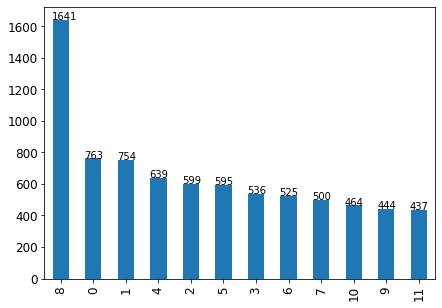

In [0]:
ax = data_frame['target'].value_counts().plot(kind='bar', figsize=(7,5), fontsize=12);
ax.set_alpha(0.8)

totals = []

for i in ax.patches:
    totals.append(i.get_height())

total = sum(totals)

for i in ax.patches:
    ax.text(i.get_x()-.03, i.get_height()+.5, i.get_height(), fontsize=10)

In [0]:
data_labels = data_frame['target']
data_features = data_frame.drop('target',axis=1)

near_miss = NearMiss(random_state=42)
x_undersampled, y_undersampled = near_miss.fit_sample(data_features, data_labels)

print(x_undersampled.shape)
print(y_undersampled.shape)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarni

(5244, 2028)
(5244,)


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [0]:
data_features_df = pd.DataFrame(data = x_undersampled[0:,0:], 
                                index = [i for i in range(x_undersampled.shape[0])],
                                columns = [str(i) for i in range(x_undersampled.shape[1])])

data_labels_df = pd.DataFrame(data = y_undersampled[0:], 
                                index = [i for i in range(y_undersampled.shape[0])],
                                columns = ['target'])

data_frame_undersampled = data_features_df.join(data_labels_df)

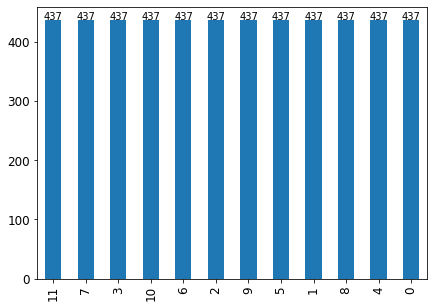

In [0]:
ax = data_frame_undersampled['target'].value_counts().plot(kind='bar', figsize=(7,5), fontsize=12);
ax.set_alpha(0.8)

totals = []

for i in ax.patches:
    totals.append(i.get_height())

total = sum(totals)

for i in ax.patches:
    ax.text(i.get_x()-.03, i.get_height()+.5, i.get_height(), fontsize=10)

In [0]:
data_frame_shuffled_once = data_frame_undersampled.sample(frac=1)
data_frame_shuffled_twice = data_frame_shuffled_once.sample(frac=1)
data_frame_shuffled_twice.sample(3)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,1989,1990,1991,1992,1993,1994,1995,1996,1997,1998,1999,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022,2023,2024,2025,2026,2027,target
926,0.0,0.005988,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.011976,...,0.0,0.0,0.0,0.0,0.0,0.005988,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2
760,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.022222,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
582,0.0,0.000000,0.0,0.0,0.0,0.0,0.008547,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.008547,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1


In [0]:
target_counts = data_frame['target'].value_counts()
batch_size = 32
beta = .001
learning_rate = 0.001
num_epoch = 101
num_k_splits = 10
num_features = data_frame.shape[1] - 1
num_labels = target_counts.shape[0]

**Helper Functions**

In [0]:
def to_onehot(y):
  data = np.zeros((num_labels))
  data[y] = 1
  return data

In [0]:
def to_label_list(results):
  label_list = []

  for result in results:
    prediction_label = np.argmax(result)
    label_list.append(prediction_label)
  
  return label_list

In [0]:
def get_accuracy(labels, predictions):
  test_batch_size = predictions.shape[0]
  total_correct_prediction = np.sum(np.argmax(predictions, axis=1) == np.argmax(labels, axis=1))
  accuracy = 100.0 * total_correct_prediction / test_batch_size  
  
  return accuracy

In [0]:
def get_fmeasure(labels, predictions):
  
  fmeasures = {}

  for i in range(num_labels):
    fmeasure_data_dict = {
      "gi": 0,
      "pi_intersect_gi": 0,
    }

    fmeasures[str(i)] = fmeasure_data_dict 
    fmeasure_data_dict = {}

  for i in range(len(labels)):
    label = labels[i]
    prediction = predictions[i]
    fmeasures[str(label)]['gi'] += 1

    if prediction == label:
      fmeasures[str(label)]['pi_intersect_gi'] += 1
  
  total_fmeasure_score = 0

  for i in range(num_labels):
    fmeasure_data = fmeasures[str(i)]
    
    gi = fmeasure_data['gi']
    pi_intersect_gi = fmeasure_data['pi_intersect_gi']
    
    fmeasure_score = (2 * pi_intersect_gi)/(2 * gi)
    total_fmeasure_score += fmeasure_score

  fmeasure_score = total_fmeasure_score / num_labels

  return fmeasure_score



Fold: 1


test_accuracy:  77.52380952380952
test_fmeasure:  0.7755461592670895


confusion matrix


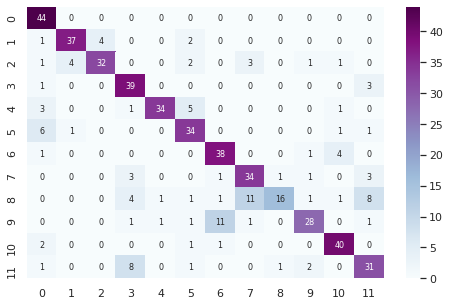



Fold: 2


test_accuracy:  79.04761904761905
test_fmeasure:  0.7906095842142354


confusion matrix


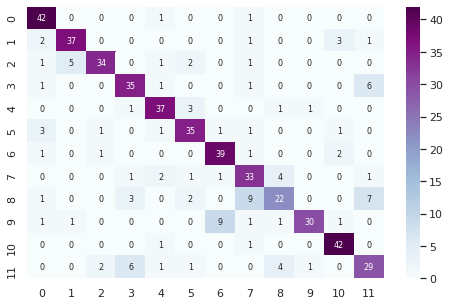



Fold: 3


test_accuracy:  80.0
test_fmeasure:  0.8001673713883016


confusion matrix


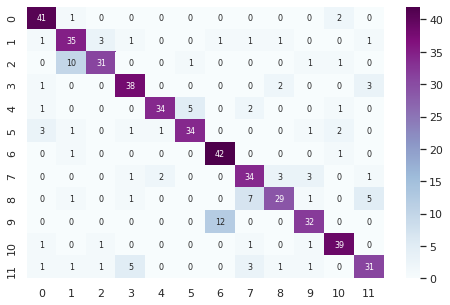



Fold: 4


test_accuracy:  78.85714285714286
test_fmeasure:  0.7889358703312191


confusion matrix


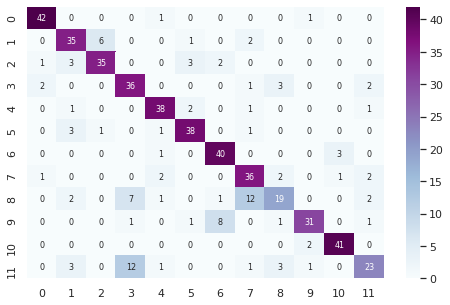



Fold: 5


test_accuracy:  77.29007633587786
test_fmeasure:  0.7731236786469345


confusion matrix


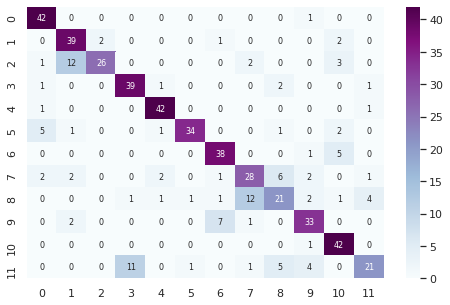



Fold: 6


test_accuracy:  79.9618320610687
test_fmeasure:  0.7994186046511627


confusion matrix


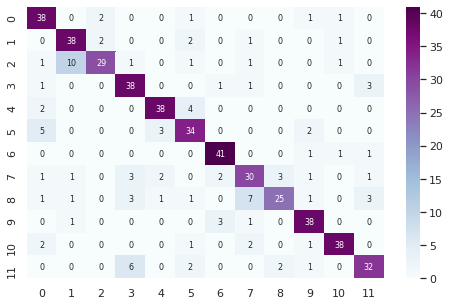



Fold: 7


test_accuracy:  81.29770992366412
test_fmeasure:  0.8126761804087385


confusion matrix


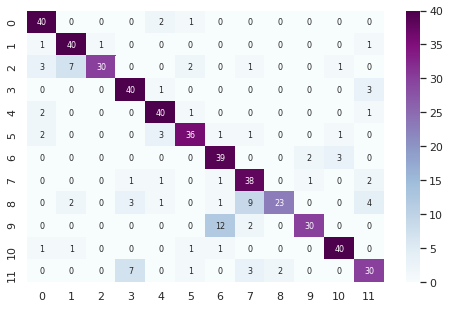



Fold: 8


test_accuracy:  78.81679389312977
test_fmeasure:  0.7873502466525722


confusion matrix


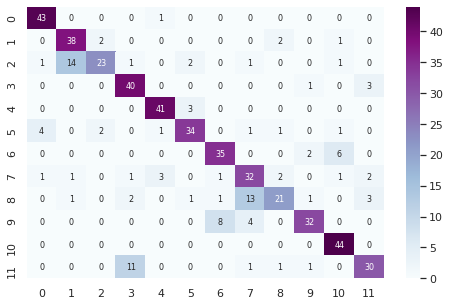



Fold: 9


test_accuracy:  78.43511450381679
test_fmeasure:  0.7849277660324172


confusion matrix


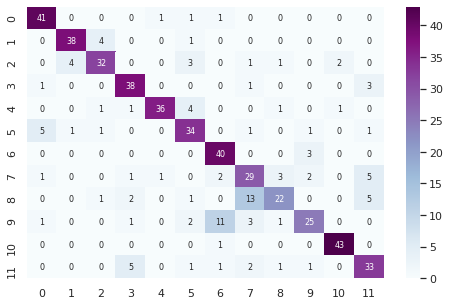



Fold: 10


test_accuracy:  76.90839694656489
test_fmeasure:  0.7691596194503171


confusion matrix


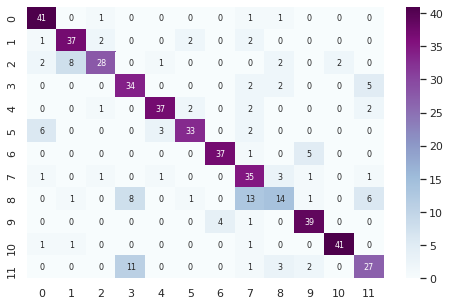

In [0]:
data_labels = data_frame_shuffled_twice['target'].to_numpy()
data_features = data_frame_shuffled_twice.drop('target',axis=1).to_numpy()

fold_counter = 1
strat_kfold = StratifiedKFold(n_splits= num_k_splits)

for train_index, test_index in strat_kfold.split(data_features, data_labels):

  print("\n==================================\n")
  print("Fold: %d" % fold_counter)
  print("\n")
  
  kfold_train_features = data_features[train_index]
  kfold_train_labels = data_labels[train_index]

  kfold_test_features = data_features[test_index]
  kfold_test_labels = data_labels[test_index]
  kfold_test_labels_onehot_encoded = np.array([to_onehot(label) for label in kfold_test_labels])

  classifier = LogisticRegression(random_state=0, multi_class='multinomial', solver='newton-cg')
  model = classifier.fit(kfold_train_features, kfold_train_labels)
  
  test_prediction = model.predict(kfold_test_features)
  test_prediction_proba = model.predict_proba(kfold_test_features)

  test_accuracy = get_accuracy(kfold_test_labels_onehot_encoded, test_prediction_proba)
  print('test_accuracy: ', test_accuracy)

  data_test_label_list = to_label_list(kfold_test_labels_onehot_encoded)
  test_predictions_label_list = to_label_list(test_prediction_proba)
  test_fmeasure = get_fmeasure(data_test_label_list, test_predictions_label_list)
  print('test_fmeasure: ', test_fmeasure)
  print("\n")
  
  # classification report
  # test_classification_report = classification_report(kfold_test_labels, test_prediction)
  # print('classification report')
  # print(test_classification_report)

  test_confusion_matrix = confusion_matrix(kfold_test_labels, test_prediction)
  confusion_matrix_df = pd.DataFrame(test_confusion_matrix, range(num_labels), range(num_labels))
  
  plt.figure(figsize=(8,5))
  sn.set(font_scale=1.0)
  sn.heatmap(confusion_matrix_df, annot=True, fmt='g', cmap="BuPu", annot_kws={"size": 8}) 

  print('confusion matrix')
  plt.show()

  # model_name = 'model_sastrawi_{}.pkl'.format(fold_counter)

  # pickle.dump(model, open(model_name,'wb'))

  fold_counter += 1

In [0]:
# near_miss = SMOTE()
# x_undersampled, y_undersampled = near_miss.fit_sample(data_features, data_labels)

# print(x_undersampled.shape)
# print(y_undersampled.shape)

In [0]:
# smk = SMOTETomek(random_state=42)
# x_undersampled, y_undersampled = smk.fit_sample(data_features, data_labels)

# print(x_undersampled.shape)
# print(y_undersampled.shape)